In [16]:
import pandas as pd
import numpy as np
PoliceIncident_Original=pd.read_csv("datasets/Police_Incident_Reports.csv")
Location = PoliceIncident_Original["Location"].copy()
Date_Occured = PoliceIncident_Original["Date Occured"].copy()
Date_Reported = PoliceIncident_Original["Date Reported"].copy()
PoliceIncident=PoliceIncident_Original.drop(["Police Case Number",'Offense Description',"Date Occured","Date Found","Offense Code","Subdivision","Date Reported","Location"],axis=1)

LongLatt = r'(\d+\.\d*\,\s\-\d+\.\d*)'
Location_Inc=Location.str.extract(LongLatt, expand=False).str.rsplit(",",expand=True)
Lattitude_Inc=pd.DataFrame(Location_Inc[0]).astype(float)
Longitude_Inc=pd.DataFrame(Location_Inc[1]).astype(float)
PoliceIncident=pd.merge(PoliceIncident,Lattitude_Inc,how='left',left_index=True,right_index=True)
PoliceIncident=pd.merge(PoliceIncident,Longitude_Inc,how='left',left_index=True,right_index=True)

IncidentType=PoliceIncident_Original['Offense Description'].str.split(',',expand=True,n=1)
threshold = 500 # Anything that occurs less than this will be replaced.
value_counts = IncidentType[0].value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
IncidentType[0].replace(to_remove, 'Others', inplace=True)
IncidentType[0].replace(["DRUG/ NARCOTIC VIOLATIONS","DRUG/ EQUIPMENT VIOLATIONS","OVERDOSE"], 'DRUG VIOLATIONS', inplace=True)
#["DRUG/ NARCOTIC VIOLATIONS","DRUG/ EQUIPMENT VIOLATIONS"]->'DRUG VIOLATIONS'
IncidentType[0].replace(["BURGLARY/ B & E","MOTOR VEHICLE THEFT"], 'LARCENY', inplace=True)
# ["BURGLARY/ B & E","MOTOR VEHICLE THEFT"]->'LARCENY'
IncidentType[0].replace(["WEAPON LAW VIOLATIONS","WEAPON LAW"], 'WEAPON LAW VIOLATIONS', inplace=True)
#"WEAPON LAW VIOLATIONS","WEAPON LAW"]->'WEAPON LAW VIOLATIONS'
IncidentType[0].replace(["HIT & RUN"], 'ASSAULT', inplace=True)
#["HIT & RUN"]-> 'ASSAULT
IncidentType[0].replace(["THREATEN BODILY HARM",'ANNOYING PHONE CALLS/ HARASSING COMMUNICATION'],"HARASSING COMMUNICATION", inplace=True)
#["THREATEN BODILY HARM",'ANNOYING PHONE CALLS/ HARASSING COMMUNICATION']->"HARASSING COMMUNICATION",

IncidentType=pd.DataFrame(IncidentType[0])

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
PoliceIncident_cat_encoded = encoder.fit_transform(IncidentType)
Type=pd.DataFrame(PoliceIncident_cat_encoded)
# Type[0].replace({0:1,4:1,10:2,7:2,6:2,11:2,16:2,12:2,5:3,8:3,13:3,2:3,3:3,17:3,18:3,15:4,20:4,19:4,1:5,9:5,14:5}, inplace=True)
PoliceIncident=pd.merge(PoliceIncident,Type,how='left',left_index=True,right_index=True)

PoliceIncident.rename(columns={'0_x':'Lattitude', 1:'Longitude','0_y':'Type'}, inplace=True)
PoliceIncident['Zone ID'].apply(pd.to_numeric)

Date_Reported = pd.to_datetime(Date_Reported)
Reported=((Date_Reported.dt.year*12+Date_Reported.dt.month)*30+Date_Reported.dt.day)*24 + Date_Reported.dt.hour
Reported_day=((Date_Reported.dt.year*12+Date_Reported.dt.month)*30+Date_Reported.dt.day)
Date_Occured = pd.to_datetime(Date_Occured)
Occur=((Date_Occured.dt.year*12+Date_Occured.dt.month)*30+Date_Occured.dt.day)*24 + Date_Occured.dt.hour
Occur_day=((Date_Occured.dt.year*12+Date_Occured.dt.month)*30+Date_Occured.dt.day)
PoliceIncident['Time_Intrvl'] =Reported-Occur
PoliceIncident['Time_Intrvl_day'] =Reported_day-Occur_day
PoliceIncident['Time_Intrvl'].where(PoliceIncident['Time_Intrvl'] > -1, np.nan, inplace=True)


Time_Occured=pd.DataFrame(Date_Occured.dt.hour).astype(float)
PoliceIncident=pd.merge(PoliceIncident,Time_Occured,how='left',left_index=True,right_index=True)
Time_Occured_day=pd.DataFrame(Date_Occured.dt.day).astype(float)
PoliceIncident=pd.merge(PoliceIncident,Time_Occured_day,how='left',left_index=True,right_index=True)

PoliceIncident=PoliceIncident.drop([27743, 63611,13603,61541,81206,41997,35420,20130,48317,67191,33993,36432,23839,26143,39922,82728,79301,79299])
PoliceIncident=PoliceIncident.dropna(axis=0,how='any')

C:\Users\chang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


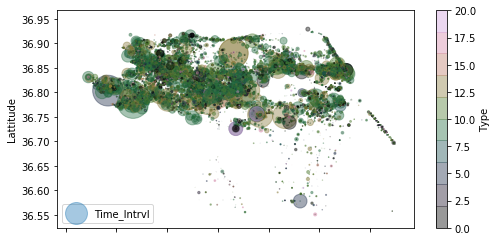

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# PoliceIncident.plot(kind="scatter", x="Longitude", y="Lattitude",alpha=0.1)
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 0.7, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)
if __name__ == '__main__':
    N =10
    PoliceIncident.plot(kind="scatter", x="Longitude", y="Lattitude",alpha=0.4,s=PoliceIncident['Time_Intrvl']/500, label="Time_Intrvl" ,c="Type",cmap=discrete_cmap(N, 'cubehelix'), colorbar=True,figsize=(8,4))

# PoliceIncident.plot(kind="scatter", x="Longitude", y="Lattitude",alpha=0.2,s=PoliceIncident['Time_Intrvl']/40, label="Time_Intrvl" ,c="Zone ID",cmap=plt.get_cmap('RdBu', 20), colorbar=True,figsize=(20,14))
# plt.legend()

In [17]:
from sklearn.model_selection import train_test_split
P_train_set, P_test_set = train_test_split(PoliceIncident, test_size=0.2, random_state=42)


corr_matrix = P_train_set.corr()
# corr_matrix["Date Occured"].sort_values(ascending=False)
IncidentType[0].value_counts()

LARCENY                      26744
ASSAULT                      20313
DESTRUCTION OF PROPERTY       9258
DRUG VIOLATIONS               8705
FRAUD                         6132
Others                        4612
HARASSING COMMUNICATION       2350
WEAPON LAW VIOLATIONS         2002
TRESPASS OF REAL PROPERTY     1154
COUNTERFEITING/ FORGERY        893
ROBBERY                        759
CRUELTY TO ANIMALS             640
UNAUTHORIZED USE OF AUTO       551
VIOLATE PROTECTIVE ORDER       530
Name: 0, dtype: int64

In [7]:
IncidentType[0]

0         DESTRUCTION OF PROPERTY
1                         LARCENY
2                         ASSAULT
3         DESTRUCTION OF PROPERTY
4                         LARCENY
5                           FRAUD
6                         LARCENY
7                           FRAUD
8                         LARCENY
9                          Others
10                        LARCENY
11                        LARCENY
12                        LARCENY
13                      HIT & RUN
14                        LARCENY
15                        LARCENY
16                        LARCENY
17                        LARCENY
18                       OVERDOSE
19                        LARCENY
20                     WEAPON LAW
21       UNAUTHORIZED USE OF AUTO
22        DESTRUCTION OF PROPERTY
23          WEAPON LAW VIOLATIONS
24                        ASSAULT
25                         Others
26                        ASSAULT
27                        LARCENY
28          WEAPON LAW VIOLATIONS
29            

In [ ]:
PoliceIncident.reindex(PoliceIncident['Longitude'].abs().sort_values(ascending=False).index)
# Lattitude=pd.DataFrame(Location[0]).astype(float) 
# Lattitude.dtypes 
# PoliceCall.info()
PoliceIncident['Zone ID'].value_counts()


PoliceCall_Original=pd.read_csv("datasets/Police_Calls_for_Service.csv")
Location = PoliceCall_Original["Location"].copy()
CallTime = PoliceCall_Original["Call Date/Time"].copy()
CloseTime = PoliceCall_Original["Close Date/Time"].copy()
PoliceCall=PoliceCall_Original.drop(["Incident Number","Report Number","On Scene Date/Time","Entry Date/Time","Dispatch Date/Time","En Route Date/Time","Subdivision"],axis=1)

LongLatt = r'(\d+\.\d*\,\s\-\d+\.\d*)'
Location=Location.str.extract(LongLatt, expand=False).str.rsplit(",",expand=True)
Lattitude=pd.DataFrame(Location[0]).astype(float)
Longitude=pd.DataFrame(Location[1]).astype(float)
PoliceCall=pd.merge(PoliceCall,Lattitude,how='left',left_index=True,right_index=True)
PoliceCall=pd.merge(PoliceCall,Longitude,how='left',left_index=True,right_index=True)
PoliceCall.rename(columns={0:'Lattitude', 1:'Longitude'}, inplace=True)

# Time_Regular=r'(\d+\:\d+\:\d+)'
# HourMinute_OnScene=OnSceneTime.str.extract(Time_Regular, expand=False)
# HourMinute_Call=CallTime.str.extract(Time_Regular, expand=False)
# AMPM_Regular=r'(AM|PM)'
# AMPM_OnScene=OnSceneTime.str.extract(AMPM_Regular, expand=False)
# AMPM_Call=CallTime.str.extract(AMPM_Regular, expand=False)

Call_time = pd.to_datetime(CallTime)
Call=((Call_time.dt.day*24+Call_time.dt.hour)*60+Call_time.dt.minute)*60 + Call_time.dt.second
Close_time = pd.to_datetime(CloseTime)
Close=((Close_time.dt.day*24+Close_time.dt.hour)*60+Close_time.dt.minute)*60 + Close_time.dt.second
PoliceCall['Time_Intrvl'] =Close-Call

Property_Original=pd.read_csv("datasets/Property_Sales.csv")
Location_P = Property_Original["Location 1"].copy()
Property= pd.DataFrame(Property_Original,columns =["Total Value","Location 1"])

Location=Location_P.str.extract(LongLatt, expand=False).str.rsplit(",",expand=True)
Lattitude_P=pd.DataFrame(Location[0])
Longitude_P=pd.DataFrame(Location[1])
Property=pd.merge(Property,Lattitude_P,how='left',left_index=True,right_index=True)
Property=pd.merge(Property,Longitude_P,how='left',left_index=True,right_index=True)
Property.rename(columns={0:'Lattitude', 1:'Longitude'}, inplace=True)